In [ ]:
!pip install ktrain
!pip install mpi4py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ktrain
from ktrain import text

In [4]:
# df = pd.read_csv('/content/consolidated.csv')
df = pd.read_csv('drive/MyDrive/Datasets/CSE4001_PDC_Project/consolidated.csv')

In [5]:
df

,Date,1,2,3,4,5,6,7,8,9,10,11,12,Label,Pct_inc,Bin_label,Up,Down
0,08-09-1998,Boeing gets Varig order,Airbus gets Emirates order,Dow set for early takeoff,CNNfn market movers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,1.936619718,Up,1,0
1,09-09-1998,UPS flies with Airbus,Boeing Airbus split order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.590673575,Down,0,1
2,05-10-1998,Boeing boosts output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,2.111324376,Up,1,0
3,07-10-1998,Raytheon cuts 14000 jobs,Open skies' at an impasse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.466793169,Down,0,1
4,08-10-1998,Wall Street struggles in pain,Selling pressure eases,Wall Street reels in pain,Wall St. shaken up,More turmoil for U.S. stocks,Yen takes second bite of bond,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.946954813,Down,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,17-02-2017,Trump and jobs: A running fact check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,0.784543054,Up,1,0
6074,21-02-2017,Move over Amazon: Here comes Walmart,Retailers report; Central bank chatter; Stock ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,0.337028512,Up,1,0
6075,22-02-2017,These 10 stocks dominate the market,How Trump could make the trade deficit look worse,Amazon brings free shipping minimum back down ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-0.747406228,Down,0,1
6076,23-02-2017,Fallen angels? Victoria's Secret sales plunge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-0.958336111,Down,0,1


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
df.head()

,Date,1,2,3,4,5,6,7,8,9,10,11,12,Label,Pct_inc,Bin_label,Up,Down
0,08-09-1998,Boeing gets Varig order,Airbus gets Emirates order,Dow set for early takeoff,CNNfn market movers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,1.936619718,Up,1,0
1,09-09-1998,UPS flies with Airbus,Boeing Airbus split order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.590673575,Down,0,1
2,05-10-1998,Boeing boosts output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,2.111324376,Up,1,0
3,07-10-1998,Raytheon cuts 14000 jobs,Open skies' at an impasse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.466793169,Down,0,1
4,08-10-1998,Wall Street struggles in pain,Selling pressure eases,Wall Street reels in pain,Wall St. shaken up,More turmoil for U.S. stocks,Yen takes second bite of bond,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.946954813,Down,0,1


In [8]:
df2 = df[['1','2','3','4','5','6','7','8','9','10','11','12','Bin_label']]
df2["News Headline"] = ""
for i in range(len(df2)):
  for j in df2.loc[i]:
    if not pd.isna(j):
      df2['News Headline'][i] = df2['News Headline'][i]+". "+str(j)
    else:
      break
df3 = df2[['News Headline','Bin_label']]
df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,News Headline,Bin_label
0,. Boeing gets Varig order. Airbus gets Emirate...,Up
1,. UPS flies with Airbus. Boeing Airbus split ...,Down
2,. Boeing boosts output,Up
3,. Raytheon cuts 14000 jobs. Open skies' at an ...,Down
4,. Wall Street struggles in pain. Selling press...,Down


In [9]:
df3.to_csv('con_3.csv')

In [10]:
df3['News Headline'][4910]

". A surprise leap in jobs wages. Thursday's tech rally"

In [11]:
x = df2['News Headline']
y= df3['Bin_label']
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [37]:
df['Bin_label'].unique

<bound method Series.unique of 0         Up
1       Down
2         Up
3       Down
4       Down
        ... 
6073      Up
6074      Up
6075    Down
6076    Down
6077      Up
Name: Bin_label, Length: 6078, dtype: object>

In [13]:
(X_train,y_train),(X_test,y_test),preprocess = text.texts_from_df(train_df = df3,
                                                                  text_column = 'News Headline',
                                                                  label_columns = 'Bin_label',
                                                                  val_df = df3,
                                                                  maxlen = 30,
                                                                  preprocess_mode = 'bert')

['Bin_label', 'Down', 'Up']
   Bin_label  Down   Up
0        0.0   0.0  1.0
1        0.0   1.0  0.0
2        0.0   0.0  1.0
3        0.0   1.0  0.0
4        0.0   1.0  0.0
['Bin_label', 'Down', 'Up']
   Bin_label  Down   Up
0        0.0   0.0  1.0
1        0.0   1.0  0.0
2        0.0   0.0  1.0
3        0.0   1.0  0.0
4        0.0   1.0  0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [14]:
df3['Bin_label'].values

array(['Up', 'Down', 'Up', ..., 'Down', 'Down', 'Up'], dtype=object)

In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0,1";  

import tensorflow as tf
mirrored_strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 6 * 2 # desired BS times 2
MODEL_NAME = 'bert'
with mirrored_strategy.scope():
    model = text.text_classifier(name = 'bert',
                             train_data = (X_train,y_train),
                             preproc = preprocess)

Is Multi-Label? False
maxlen is 30
done.


In [16]:
model = text.text_classifier(name = 'bert',
                             train_data = (X_train,y_train),
                             preproc = preprocess)

Is Multi-Label? False
maxlen is 30
done.


In [17]:
# learner = ktrain.get_learner(model = model,
#                              train_data = (X_train,y_train),
#                              val_data = (X_test,y_test),
#                              batch_size = 6)
learner = ktrain.get_learner(model = model,
                             train_data = (X_train,y_train),
                             val_data = (X_test,y_test),
                             batch_size = BATCH_SIZE)

In [23]:
hist = learner.fit_onecycle(lr = 1e-5,epochs = 10)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/10
507/507 [==============================] - 150s 295ms/step - loss: 0.0610 - accuracy: 0.9784 - val_loss: 0.0253 - val_accuracy: 0.9898
Epoch 2/10
507/507 [==============================] - 150s 295ms/step - loss: 0.0614 - accuracy: 0.9776 - val_loss: 0.0235 - val_accuracy: 0.9900
Epoch 3/10
507/507 [==============================] - 150s 295ms/step - loss: 0.0656 - accuracy: 0.9761 - val_loss: 0.0253 - val_accuracy: 0.9900
Epoch 4/10
507/507 [==============================] - 149s 294ms/step - loss: 0.0756 - accuracy: 0.9729 - val_loss: 0.0258 - val_accuracy: 0.9901
Epoch 5/10
507/507 [==============================] - 149s 294ms/step - loss: 0.0890 - accuracy: 0.9630 - val_loss: 0.0306 - val_accuracy: 0.9877
Epoch 6/10
507/507 [==============================] - 149s 294ms/step - loss: 0.0755 - accuracy: 0.9717 - val_loss: 0.0246 - val_accuracy: 0.9893
Epoch 7/10
507/507 [==============================] - 149s 29

In [26]:
history = hist.history
epochs = hist.epoch

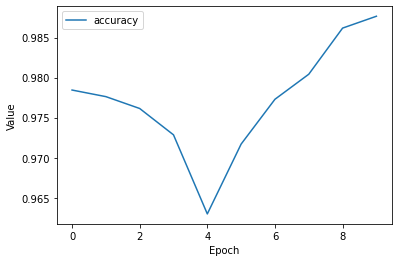

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Value")

# for m in list_of_metrics:
x = history["accuracy"]
plt.plot(epochs[0:], x[0:], label="accuracy")

plt.legend()

In [29]:
# learner.save_model('NLP_Model')
# learner.load_model('NLP_Model')
learner.save_model('drive/MyDrive/Models')
# learner.load_model('drive/MyDrive/Models')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
predictor = ktrain.get_predictor(learner.model,preprocess)

In [ ]:
data = ["Google defends growth plans. Google defends growth plans. Stocks end day higher but May is a loss. Stocks rebound ahead of Fed. Pining for a pause. U.S. asks Internet firms to keep customer info. Dec"	]

In [ ]:
predictor.predict(data)

['Down']

In [ ]:
import time

start_time = time.time()
for i in range(len(df)):
  data = df3['News Headline'][i]
  pred = predictor.predict(data)
  print(df3['Bin_label'][i],pred)
end_time = time.time()
print("Execution Time : ", (end_time - start_time))

In [36]:
df3 = pd.read_csv('con_3.csv', index_col = 0)
df3.head()

,News Headline,Bin_label
0,. Boeing gets Varig order. Airbus gets Emirate...,Up
1,. UPS flies with Airbus. Boeing Airbus split ...,Down
2,. Boeing boosts output,Up
3,. Raytheon cuts 14000 jobs. Open skies' at an ...,Down
4,. Wall Street struggles in pain. Selling press...,Down


In [30]:
%%writefile predict.py
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import mpi4py
import time


mpi4py.rc.initialize = False  # do not initialize MPI automatically
mpi4py.rc.finalize = False    # do not finalize MPI automatically

from mpi4py import MPI

MPI.Init()      # manual initialization of the MPI environment
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


df3 = pd.read_csv('con_3.csv', index_col = 0)

(X_train,y_train),(X_test,y_test),preprocess = text.texts_from_df(train_df = df3,
                                                                  text_column = 'News Headline',
                                                                  label_columns = 'Bin_label',
                                                                  val_df = df3,
                                                                  maxlen = 30,
                                                                  preprocess_mode = 'bert')

model = text.text_classifier(name = 'bert',
                             train_data = (X_train,y_train),
                             preproc = preprocess)
learner = ktrain.get_learner(model = model,
                             train_data = (X_train,y_train),
                             val_data = (X_test,y_test),
                             batch_size = 6)
learner.load_model('drive/MyDrive/Models')

predictor = ktrain.get_predictor(learner.model,preprocess)

p = len(df3)//size

if (rank != size-1) :
  for i in range(p*rank, p*(rank +1)) :
    data = df3['News Headline'][i]
    pred = predictor.predict(data)
    print("Processor : ", rank, end=" ")
    print(data, end="   ")
    print(df3['Bin_label'][i],pred)

if (rank == size - 1) :
  for i in range(p*rank, len(df3)) :
    data = df3['News Headline'][i]
    pred = predictor.predict(data)
    print("Processor : ", rank, end=" ")
    print(data, end="   ")
    print(df3['Bin_label'][i],pred)

MPI.Finalize()  

Writing predict.py


In [31]:
!mpiexec -n 4 --allow-run-as-root python predict.py

Streaming output truncated to the last 5000 lines.
Processor :  3 . Wall Street battered day 3   Down Down
Processor :  0 . Boeing settles lawsuits   Down Down
Processor :  2 . IBM is being investigated by the SEC. Facebook's mobile app just got stickier. From bullied teen to 17-year-old CEO. Google has 3.8 million GB of our photos (at least)   Up Up
Processor :  3 . Judge overturns Maryland's Wal-Mart law   Up Up
Processor :  0 . Cathay flies over forecast. Ryanair 1Q profit climbs   Down Down
Processor :  1 . Yahoo disappoints again   Down Down
Processor :  2 . Hilton: We're not scared of Airbnb. IBM buys digital part of Weather Channel. Fox has major 'technical difficulties' during World Series   Up Up
Processor :  3 . Holiday 2006: Hostage to gas prices   Up Up
Processor :  0 . FAA finds Boeing flaws?   Up Up
Processor :  2 . Online sales set to soar 11% this holiday season. This could be Google's greatest invention. Poof! Google Photos lets you hide pictures of your ex   Up Up
Pro